https://www.tensorflow.org/guide/keras/rnn?hl=ko

https://www.tensorflow.org/tutorials?hl=ko

https://deeptak.tistory.com/8

https://lv99.tistory.com/3

# RNN (Recurrent Neural Net)

<br>

- 시계열 자료, 텍스트 데이터와 같은 시퀀스 데이터를 모델링하는데 아주 좋은 신경망.
- 내부적으로 for loop을 통해 시퀀스의 시간 단계를 반복, 지금까지 본 시간 단계에 대한 정보를 인코딩.
- Keras RNN API
    - 사용 편리성 : 내장 layers.RNN, layers.LSTM, layers.GRU를 통해 빠른 구축이 가능.
    - 사용자 정의 용이성 : 사용자 정의 동작으로 자체 RNN 셀 계층을 만들고, layers.RNN과 같이 사용할 수 있음.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**내장 RNN**

<br>

- keras.layers.SimpleRNN : 이전 타임스텝의 출력이 다음 타임스텝으로 연결되는 fully-connected 된 RNN.
- keras.layers.GRU
- keras.layers.LSTM (https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

<br>

다음 예시는 정수 시퀀스를 처리하고, 각 정수를 64차원 벡터에 포함시킨 다음, LSTM 레이어를 통해 벡터 시퀀스를 처리하는 Sequential 모델.

In [3]:
model = keras.Sequential()

model.add(layers.Embedding(input_dim=1000, output_dim=64))

# 128개의 유닛을 가진 LSTM 층 추가
model.add(layers.LSTM(128))
# 출력층 추가
model.add(layers.Dense(10))

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

    numpy 1.20 버전일때 나는 에러라고 한다...
    1.19로 다운그레이드 하자.

In [2]:
model = keras.Sequential()

model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


    됐다.

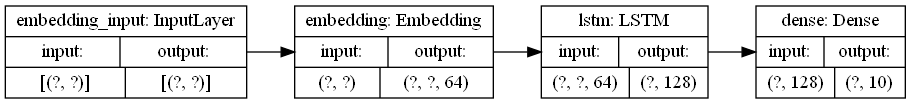

In [3]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

*Embedding Layer가 뭘 할까?*  <br>
- https://heegyukim.medium.com/keras-embedding%EC%9D%80-word2vec%EC%9D%B4-%EC%95%84%EB%8B%88%EB%8B%A4-619bd683ded6
- https://keras.io/api/layers/core_layers/embedding/
- 특정 데이터를 Vector로 바꾸는 층.
    - Vector로 변환하므로 산술 연산이 가능해지고, 머신러닝에 활용이 가능.
- **입력 데이터를 정해진 크기의 벡터로 바꿔 다음 레이어로 전달.**
    - 위 예시는 입력이 64차원의 벡터를 출력하도록 설정했음.
- **Turns positive integers (indexes) into dense vectors of fixed size.**

**RNN Layer, RNN Cell**

<br>

- RNN Cell은 Layer와는 달리 단일 timestamp만 처리함.
- RNN(LSTMCell(10)) == LSTM(10). 동일한 결과를 생성함.
- SimpleRNNCell, GRUCell, LSTMCell 의 3개의 내장 cell이 있음.

## Cross-batch statefulness

<br>

- 매우 긴 시퀀스를 처리할 때, **크로스-배치 상태저장 패턴**을 사용할 수 있음.
    - 보통 RNN 층 내부 상태는 **새로운 배치가 인식될 때 마다 상태가 재설정** 됨.
        - 층에서 볼 수 있는 샘플들은 과거와 독립적인 것으로 가정.
        - 층은 주어진 샘플을 처리하는 동안에만 상태를 유지.
- 시퀀스가 매우 긴 경우, **시퀀스를 더 짧은 시퀀스로 나눈다**.
- 층의 **상태를 재설정 하지 않고**, **짧은 시퀀스를 RNN 층에 순차적으로 공급**.
    - 이렇게 하게 되면 **층이 한번의 1개의 하위 시퀀스만을 받더라도 전체에 대한 정보를 유지**할 수 있다.
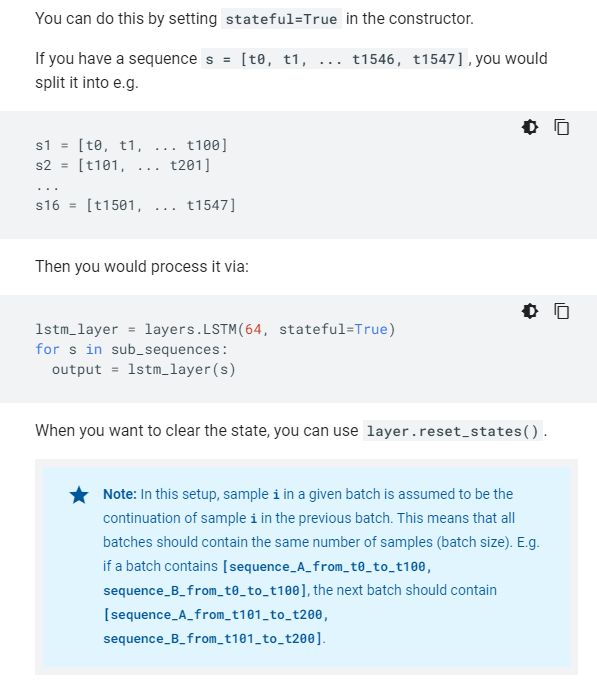

    stateful = True
        한 바퀴(Time step)가 종료된 이후에도 상태를 초기화 하지 않고, 
        다음 바퀴에 초기 상태로 사용.
        
    batch의 sample을 계산한 상태가 다음 batch의 sample을 계산하기 위한 초기상태로 재사용 된다.
    statefulness.
        데이터들 간 상관관계가 있다면 stateful=True로 하고 학습하면 된다는 소리가 아닐까?
        
  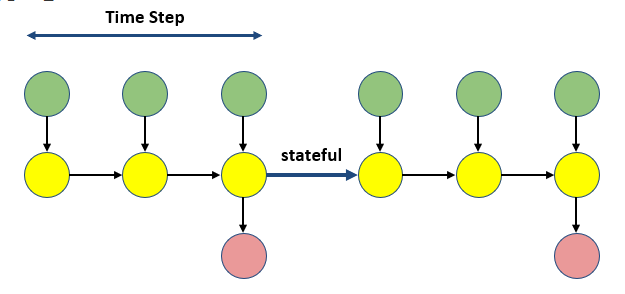

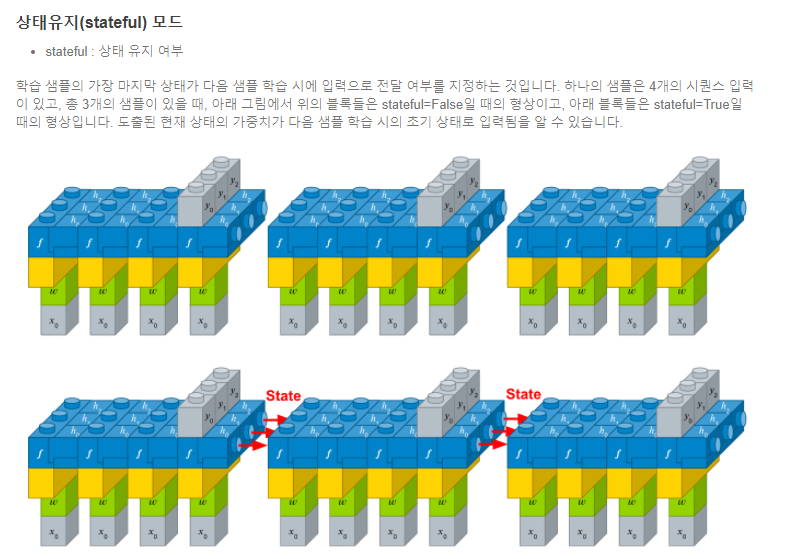

                                        생각한게 맞는듯
  

In [10]:
# 코드를 통해서 한번 보자.
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
print(lstm_layer.states)
output = lstm_layer(paragraph1)
print(lstm_layer.states)
output = lstm_layer(paragraph2)
print(lstm_layer.states)
output = lstm_layer(paragraph3)
print(lstm_layer.states)

# reset_states()를 통해 초기상태로 되돌릴 수 있음.
# initial_state를 제공하지 않으면, 전부 0으로 초기화 됨.
lstm_layer.reset_states()
print(lstm_layer.states)

[None, None]
[<tf.Variable 'lstm_6/Variable:0' shape=(20, 64) dtype=float32, numpy=
array([[-0.3567641 ,  0.22052127,  0.15577671, ..., -0.44008473,
         0.17923574, -0.09118061],
       [-0.3365199 ,  0.39129263,  0.15348728, ..., -0.48655123,
         0.12205403, -0.15984966],
       [-0.37331006,  0.29167387,  0.16216356, ..., -0.46989483,
         0.22411406, -0.21619411],
       ...,
       [-0.3198835 ,  0.22049007,  0.16560939, ..., -0.4080863 ,
         0.14189203, -0.08328443],
       [-0.3700796 ,  0.34970865,  0.07559434, ..., -0.34485343,
         0.17695409, -0.03913674],
       [-0.36029914,  0.24939816,  0.10572021, ..., -0.37170914,
         0.171019  , -0.09915227]], dtype=float32)>, <tf.Variable 'lstm_6/Variable:0' shape=(20, 64) dtype=float32, numpy=
array([[-0.9735891 ,  0.36793455,  0.35673594, ..., -1.082366  ,
         0.3347117 , -0.17458057],
       [-1.0502303 ,  0.73090196,  0.3259671 , ..., -1.0269446 ,
         0.21492215, -0.3448308 ],
       [-1.07142

## 성능 최적화 및 CuDNN Kernel

<br>

- 내장 LSTM 및 GRU 층은 GPU을 사용할 수 있을때 기본적으로 CuDNN 커널을 사용하도록 되어있음.
- 이전 CuDNNLSTM, CuDNNGRU 층은 사용되지 않음.

<br>

**CuDNN 커널?**
- NVDIA에서 제공한 그래픽카드, CUDA 설치해서 같이 쓸수있는거. 예전에 해봤던거 같은데
- 내장 LSTM, GRU 층의 기본값을 변경하게 되면 CuDNN 커널을 사용할 수 없음. 다음과 같은 경우.
    - activation을 tanh에서 다른걸로 변경하는 경우
    - recurrent_activation을 sigmoid에서 다른걸로 변경하는 경우
    - 0보다 큰 recurrent_dropout을 쓰는 경우
    - unroll을 True로 설정한 경우. (내부적으로 있는 while_loop를 for loop로 분해함. 그렇대요)
    - use_bias를 False로 설정한 경우
    - 입력 데이터가 정확히 오른쪽 패딩처리 되어있지 않아 마스킹을 사용하는 경우 (대부분 이 경우라 함)
- 가능한 경우 CuDNN 커널을 쓰는게 속도가 훨~씬 빠르다.

일단 GPU를 쓸 수 있는지 확인을 해보자.

In [14]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15792432544394128863]

    어라...
    GPU를 쓸려면 그래픽 카드가 있어야 하고,
    그에 맞는 드라이버와 적절한 버전의 CUDA, CuDNN이 설치되어 있어야 한다고 한다.
    
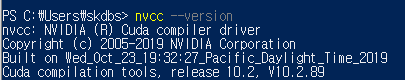

    ??? 있는데??